# Data Science for Music

## Dataset Sources:

1. My Winamp's music library's Media Library Export - can be found under data/music_library_export.xml
2. My Last.fm account's scrobbles (time series of when each song was played) extracted from [here](https://lastfm.ghan.nl/export/) - can be found under data/lastfm-scrobbles-edchapa.csv
3. [GTZAN Dataset - Music Genre Classification](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) from Kaggle.

## Process

First, let's install all the libraries we'll be using.

In [ ]:
%pip install jupyter
%pip install altair
%pip install joblib
%pip install nbformat
%pip install numpy
%pip install plotly-express
%pip install polars
%pip install scikit-learn
%pip install streamlit
%pip install tensorflow
%pip install xmltodict
%pip install ydata-profiling

For this project I exported my song library from Winamp, which contains information like track name, artist, genre, etc.

However, the export is in iTunes XML format, so I will have to convert it into csv format first using Python's xmltodict and csv libraries. First we read the xml file, and create the output csv file.

In [1]:
import xmltodict, csv

with open('data/music_library_export.xml') as xml_file:
    xml_file = xmltodict.parse(xml_file.read())

csv_file = open("data/music_library_export.csv", "w", newline='')
csv_file_writer = csv.writer(csv_file)

We will use the xml file's keys as the column names for the csv file.

In [2]:
xml_file_keys = ["Track ID", "Name", "Artist", "Album Artist", "Album",
                 "Genre", "Comments", "Kind", "Size", "Total Time",
                 "Track Number", "Year", "Bit Rate", "Track Count",
                 "Composer", "Publisher", "Location", "File Folder Count",
                 "Library Folder Count", "Date Modified", "Date Added"]
csv_file_writer.writerow(xml_file_keys)

208

Now we will write a row in the csv file per song in the xml file. Since the xml file is not an xml standard file, we will need to manually parse the values inside the dictionaries contained in it, and process each type of key separately. Since not all songs contain all fields, we will use two counters to keep track of the skipped integer and string values (which are tracked separately in the xml file's dictionary) so we can use them to write the rest of the values in the right column on the csv file. Otherwise, the values in the resulting csv file may be off whenever a song had missing values in the original xml file.

In [3]:
for song in xml_file['plist']['dict']['dict']['dict']:
    song_info = ['' for i in range(len(xml_file_keys))]
    skipped_integers = 0
    skipped_strings = 0
    if "Track ID" in song['key']:
        song_info[0] = song['integer'][0]
    else:
        skipped_integers += 1
    if "Name" in song['key']:
        song_info[1] = song['string'][0]
    else:
        skipped_strings += 1
    if "Artist" in song['key']:
        song_info[2] = song['string'][1 - skipped_strings]
    else:
        skipped_strings += 1
    if "Album Artist" in song['key']:
        song_info[3] = song['string'][2 - skipped_strings]
    else:
        skipped_strings += 1
    if "Album" in song['key']:
        song_info[4] = song['string'][3 - skipped_strings]
    else:
        skipped_strings += 1
    if "Genre" in song['key']:
        song_info[5] = song['string'][4 - skipped_strings]
    else:
        skipped_strings += 1
    if "Comments" in song['key']:
        song_info[6] = song['string'][5 - skipped_strings]
    else:
        skipped_strings += 1
    if "Kind" in song['key']:
        song_info[7] = song['string'][6 - skipped_strings]
    else:
        skipped_strings += 1
    if "Size" in song['key']:
        song_info[8] = song['integer'][1 - skipped_integers]
    else:
        skipped_integers += 1
    if "Total Time" in song['key']:
        song_info[9] = song['integer'][2 - skipped_integers]
    else:
        skipped_integers += 1
    if "Track Number" in song['key']:
        song_info[10] = song['integer'][3 - skipped_integers]
    else:
        skipped_integers += 1
    if "Year" in song['key']:
        song_info[11] = song['integer'][4 - skipped_integers]
    else:
        skipped_integers += 1
    if "Bit Rate" in song['key']:
        song_info[12] = song['integer'][5 - skipped_integers]
    else:
        skipped_integers += 1
    if "Track Count" in song['key']:
        song_info[13] = song['integer'][6 - skipped_integers]
    else:
        skipped_integers += 1
    if "Composer" in song['key']:
        song_info[14] = song['string'][7 - skipped_strings]
    else:
        skipped_strings += 1
    if "Publisher" in song['key']:
        song_info[15] = song['string'][8 - skipped_strings]
    else:
        skipped_strings += 1
    if "Location" in song['key']:
        song_info[16] = song['string'][9 - skipped_strings]
    if "File Folder Count" in song['key']:
        song_info[17] = song['integer'][7 - skipped_integers]
    else:
        skipped_integers += 1
    if "Library Folder Count" in song['key']:
        song_info[18] = song['integer'][8 - skipped_integers]
    if "Date Modified" in song['key']:
        song_info[19] = song['date'][0]
    if "Date Added" in song['key']:
        song_info[20] = song['date'][1]
    csv_file_writer.writerow(song_info)
csv_file.close()

Now we will read the csv file into a Polars DataFrame, and display the first rows.

In [1]:
import polars as pl
songs_df = pl.read_csv('data/music_library_export.csv')
songs_df.head()

Track ID,Name,Artist,Album Artist,Album,Genre,Comments,Kind,Size,Total Time,Track Number,Year,Bit Rate,Track Count,Composer,Publisher,Location,File Folder Count,Library Folder Count,Date Modified,Date Added
i64,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,str
0,"""A Story Of Boy…","""Mychael Danna …","""Mychael Danna …","""(500) Days Of …","""Soundtrack""",null,"""MPEG audio fil…",1529041,95000,1,2009,128,16,null,null,"""file://localho…",-1,-1,"""2009-11-06T05:…","""2023-10-23T02:…"
1,"""Us""","""Regina Spektor…","""Regina Spektor…","""(500) Days Of …","""Soundtrack""",null,"""MPEG audio fil…",4640293,289000,2,2009,128,16,null,null,"""file://localho…",-1,-1,"""2009-11-06T05:…","""2023-10-23T02:…"
2,"""There Is A Lig…","""The Smiths""","""The Smiths""","""(500) Days Of …","""Soundtrack""",null,"""MPEG audio fil…",3904714,243000,3,2009,128,16,null,null,"""file://localho…",-1,-1,"""2009-11-06T05:…","""2023-10-23T02:…"
3,"""Bad Kids""","""Black Lips""","""Black Lips""","""(500) Days Of …","""Soundtrack""",null,"""MPEG audio fil…",2056471,128000,4,2009,128,16,null,null,"""file://localho…",-1,-1,"""2009-11-06T05:…","""2023-10-23T02:…"
4,"""Please, Please…","""The Smiths""","""The Smiths""","""(500) Days Of …","""Soundtrack""",null,"""MPEG audio fil…",1805315,112000,5,2009,128,16,null,null,"""file://localho…",-1,-1,"""2009-11-06T05:…","""2023-10-23T02:…"


Now I would like to see how many genres we have. For that, we will select the genres column from the DataFrame and display its full contents by casting it into a numpy array.

In [2]:
songs_df.select(
    pl.col('Genre')
).unique().sort("Genre").to_numpy()


array([[None],
       ['(255)'],
       ['.'],
       ['AOR Classic Rock'],
       ['Alt Rock'],
       ['Alt. Rock'],
       ['Alternative'],
       ['Alternative & Punk'],
       ['Alternative Rock'],
       ['Alternative, Rock'],
       ['Alternativo'],
       ['Ambient'],
       ['Ambient Alternative'],
       ['Ambient Techance'],
       ['Anime'],
       ['Anti-folk'],
       ['Arena/Power Metal'],
       ['Avantgarde'],
       ['Ballad'],
       ['Banda sonora'],
       ['Black Metal'],
       ['Blues'],
       ['Brit Pop'],
       ['Brit-pop'],
       ['Campfire Rock'],
       ['Chiptune'],
       ['Choral'],
       ['Classic Hard Rock'],
       ['Classic Pop Punk'],
       ['Classic Rock'],
       ['Classical'],
       ['Cosmic Tones for Mental Therapy'],
       ['Country'],
       ['Dance'],
       ['Dance & DJ'],
       ['Dance / Disco'],
       ['Death Metal'],
       ['Desert Rock'],
       ['Down-tempo / Pop / Alternativa'],
       ['Dubstep'],
       ['Duck Remixes'],
  

## Data Imputation

We can see there are some genres that are repeated but with slight spelling or language differences, so we will try to rename them so they match the rest. We will also remove values that are not actual genres (e.g. 'unknown') and turn them into null values so we can later remove them if necessary.

In [3]:
genres = songs_df.select(
    pl.col("Genre").map_elements(
        lambda x: "Alternative" if x == "Alternativo" else x)
    .map_elements(
        lambda x: "Electronic" if x == "Electronica" else x)
    .map_elements(
        lambda x: "Electronic Pop" if x in ["Pop Electronica", "Electronica / Pop"] else x)
    .map_elements(
        lambda x: "Indie" if x == "indie" else x)
    .map_elements(
        lambda x: "Indie Rock" if x in ["Rock/Indie", "Indie/Rock", "General Indie Rock"] else x)
    .map_elements(
        lambda x: "Miscellaneous" if x == "misc" else x)
    .map_elements(
        lambda x: "Soundtrack" if x in ["soundtrack", "Banda sonora"] else x)
    .map_elements(
        lambda x: "Thrash Metal" if x == "Thrash Metal" else x)
    .map_elements(
        lambda x: "Alt Rock" if x in ["Alt. Rock", "Alternative Rock", "Rock alternativo",
                                      "Alternative, Rock", "General Alternative Rock"] else x)
    .map_elements(
        lambda x: "Brit Pop" if x == "Brit-pop" else x)
    .map_elements(
        lambda x: "Pop Rock" if x in ["Pop/Rock", "Pop/Rock 2000's"] else x)
    .map_elements(
        lambda x: "Pop" if x == "General Pop" else x)
    .map_elements(
        lambda x: "Folk" if x == "General Folk" else x)
    .map_elements(
        lambda x: "Rock" if x in ["General Rock", "Rock En General", "Rock en general", "Rock @",
                                  "rock"] else x)
    .map_elements(
        lambda x: "Heavy Metal" if x == "Rock Duro Y Heavy" else x)
    .map_elements(
        lambda x: "Hip Hop/Rap" if x == "General Rap/Hip-Hop" else x)
    .map_elements(
        lambda x: "Bitpop" if x == "bitpop" else x)
    .map_elements(
        lambda x: "Chillstep" if x == "chillstep" else x)
    .map_elements(
        lambda x: "Chiptune" if x == "chiptune" else x)
    .map_elements(
        lambda x: None if x in ["genre", "default", ".", "(255)", "Other"] else x)
    .map_elements(
        lambda x: "Unclassifiable" if x == "General Unclassifiable" else x)
    .map_elements(
        lambda x: "Soft Rock / Alternative Folk / Folk / Rock" if x == "soft rock/alternative folk/folk/rock" else x)
    .alias("Genre")
).to_series()

songs_df = songs_df.with_columns(genres.alias("Genre"))
songs_df.select(
    pl.col('Genre')
).unique().sort("Genre").to_numpy()


array([[None],
       ['AOR Classic Rock'],
       ['Alt Rock'],
       ['Alternative'],
       ['Alternative & Punk'],
       ['Ambient'],
       ['Ambient Alternative'],
       ['Ambient Techance'],
       ['Anime'],
       ['Anti-folk'],
       ['Arena/Power Metal'],
       ['Avantgarde'],
       ['Ballad'],
       ['Bitpop'],
       ['Black Metal'],
       ['Blues'],
       ['Brit Pop'],
       ['Campfire Rock'],
       ['Chillstep'],
       ['Chiptune'],
       ['Choral'],
       ['Classic Hard Rock'],
       ['Classic Pop Punk'],
       ['Classic Rock'],
       ['Classical'],
       ['Cosmic Tones for Mental Therapy'],
       ['Country'],
       ['Dance'],
       ['Dance & DJ'],
       ['Dance / Disco'],
       ['Death Metal'],
       ['Desert Rock'],
       ['Down-tempo / Pop / Alternativa'],
       ['Dubstep'],
       ['Duck Remixes'],
       ['Duet'],
       ['EDM: Dubstep'],
       ['EDM: Electro House'],
       ['EPM'],
       ['Easy Listening'],
       ['Electro'],
       [

Since we don't want null values in the Genre and Year columns, we will remove them.

In [4]:
songs_df = songs_df.drop_nulls(["Genre"])
songs_df = songs_df.drop_nulls(["Year"])

Some songs have invalid years so let's filter those out as well.

In [5]:
songs_df = songs_df.filter(pl.col('Year') > 1000).filter(pl.col('Year') < 2024)

Some songs have a total duration of zero so we'll filter those out as well.

In [6]:
songs_df = songs_df.filter(pl.col('Total Time') > 0)

We will finally remove the Comments, File Folder Count, Library Folder Count, Kind, and Location columns since they don't contain useful/relevant data.

In [7]:
songs_df.drop_in_place("Comments")
songs_df.drop_in_place("File Folder Count")
songs_df.drop_in_place("Library Folder Count")
songs_df.drop_in_place("Kind")
songs_df.drop_in_place("Location")
songs_df.head()

Track ID,Name,Artist,Album Artist,Album,Genre,Size,Total Time,Track Number,Year,Bit Rate,Track Count,Composer,Publisher,Date Modified,Date Added
i64,str,str,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,str
0,"""A Story Of Boy…","""Mychael Danna …","""Mychael Danna …","""(500) Days Of …","""Soundtrack""",1529041,95000,1,2009,128,16,null,null,"""2009-11-06T05:…","""2023-10-23T02:…"
1,"""Us""","""Regina Spektor…","""Regina Spektor…","""(500) Days Of …","""Soundtrack""",4640293,289000,2,2009,128,16,null,null,"""2009-11-06T05:…","""2023-10-23T02:…"
2,"""There Is A Lig…","""The Smiths""","""The Smiths""","""(500) Days Of …","""Soundtrack""",3904714,243000,3,2009,128,16,null,null,"""2009-11-06T05:…","""2023-10-23T02:…"
3,"""Bad Kids""","""Black Lips""","""Black Lips""","""(500) Days Of …","""Soundtrack""",2056471,128000,4,2009,128,16,null,null,"""2009-11-06T05:…","""2023-10-23T02:…"
4,"""Please, Please…","""The Smiths""","""The Smiths""","""(500) Days Of …","""Soundtrack""",1805315,112000,5,2009,128,16,null,null,"""2009-11-06T05:…","""2023-10-23T02:…"


## EDA

First, let's see how many songs we have of each genre.

In [12]:
songs_by_genre = songs_df.select(
    pl.col('Genre')
).to_series().value_counts()
songs_by_genre

Genre,counts
str,u32
"""Gangsta Rap""",16
"""Goth""",1
"""Rock/Pop""",24
"""Hip Hop/Rap""",18
"""Indie/Folk""",1
"""Progressive Ro…",9
"""Grunge""",13
"""Hard Rock""",303
"""Metal""",776


Now let's get a chart of the top 10 genres with most songs using Altair, and highlight the one with most songs.

In [13]:
import altair as alt


top_10_genres = songs_by_genre.top_k(10, by="counts")
top_genre = top_10_genres.top_k(1, by="counts").to_numpy()[0][0]
alt.Chart(top_10_genres, title="Top 10 Genres").mark_bar().encode(
    x=alt.X('counts', title="Songs"),
    y='Genre',
    color=alt.condition(
        alt.datum.Genre == top_genre,
        alt.value('orange'),
        alt.value('steelblue')
    )
)

alt.Chart(...)

Let's now see what's the average song duration per Genre. The duration is in the Total Time column in milliseconds, so we will divide it by 60000 to get the value in minutes, and round it up to 1 decimal.

In [13]:
avg_duration_per_genre = songs_df.group_by('Genre').agg(
    (pl.mean('Total Time')/60000).round(1).alias('Minutes')
)
avg_duration_per_genre

Genre,Minutes
str,f64
"""Brit Pop""",5.5
"""Folk""",3.7
"""Noise""",4.2
"""Rock/Indie/Alt…",3.0
"""Electronic Pop…",3.9
"""Hip-Hop""",4.2
"""Game""",2.4
"""Garage Punk""",2.4
"""Hardcore""",3.9


And now let's get the top 10 Genres with the longest average song duration.

In [14]:
top_10_avg_duration = avg_duration_per_genre.top_k(10, by="Minutes")
top_10_avg_duration

Genre,Minutes
str,f64
"""Hardstyle""",60.0
"""Progressive Ro…",9.1
"""Ballad""",9.0
"""Progressive Me…",8.2
"""Psychedelia""",7.6
"""Campfire Rock""",7.4
"""Ambient""",7.2
"""Indie/Post Roc…",7.0
"""Ambient Techan…",6.8


And finally let's plot them in Altair highlighting the one with the longest average duration.

In [15]:
top_duration = avg_duration_per_genre.top_k(1, by="Minutes").to_numpy()[0][1]
alt.Chart(top_10_avg_duration, title="Top 10 AVG Durations By Genre").mark_bar().encode(
    x=alt.X('Genre', axis=alt.Axis(labelAngle=-45)),
    y="Minutes",
    color=alt.condition(
        alt.datum.Minutes == top_duration,
        alt.value('orange'),
        alt.value('steelblue')
    )
).properties(width=400)

alt.Chart(...)

Now let's see how many songs we have per Year.

In [16]:
songs_per_year = songs_df.select(
    pl.col('Name').alias('Songs'),
    pl.col('Year')
).group_by('Year').agg(
    pl.count('Songs')
).sort(by='Year')
songs_per_year

Year,Songs
i64,u32
1950,1
1951,1
1964,2
1965,1
1966,2
1967,14
1968,12
1969,48
1970,38


And finally let's plot them on an Altair chart, and highlight the year with most songs.

In [17]:
top_year = songs_per_year.top_k(1, by="Songs").to_numpy()[0][0]
alt.Chart(songs_per_year, title="Song Count per Year").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(labelAngle=-45)),
    y="Songs:Q",
    color=alt.condition(
        alt.datum.Year == top_year,
        alt.value('orange'),
        alt.value('steelblue')
    )
)

alt.Chart(...)

Now, let's see how many songs are there per bit rate.

In [18]:
songs_by_bitrate = songs_df.group_by('Bit Rate').agg(
    (pl.count('Name').alias('Count'))
).select(pl.col('Bit Rate').alias('Bitrate'), pl.col('Count'))
songs_by_bitrate

Bitrate,Count
i64,u32
959,1
298,6
277,16
956,1
146,6
140,2
274,21
149,1
179,12


Now let's get the top 5 bit rates with most songs.

In [128]:
top_5_bitrates = songs_by_bitrate.top_k(5, by="Count")
top_5_bitrates

Bitrate,Count
i64,u32
320,1690
192,1658
128,887
256,528
160,142


And now let's plot all the top 5 most popular bit rates, and highlight the one with the highest song count.

In [133]:
songs_by_bitrate = songs_df.group_by('Bit Rate').agg(
    (pl.count('Name').alias('Count'))
).select(pl.col('Bit Rate').alias('Bitrate'), pl.col('Count'))
alt.Chart(
    top_5_bitrates,
    title="Top 5 Bit Rates").mark_arc(innerRadius=70).encode(
    color=alt.Color("Bitrate", title="Bit Rate (kb/s)", type="nominal",
                    sort='ascending',
                    scale=alt.Scale(scheme='plasma')),
    theta="Count"
)

alt.Chart(...)

Now, let's see how many genres have the same average bit rate. For that, first let's get the average bitrate per genre.

In [8]:
avg_bitrate_per_genre = songs_df.group_by('Genre').agg(
    (pl.mean('Bit Rate').alias('Average Bit Rate'))
)
avg_bitrate_per_genre

Genre,Average Bit Rate
str,f64
"""Unclassifiable…",223.833333
"""Latin Rock""",256.0
"""Ambient Techan…",128.0
"""Electro House""",320.0
"""Duck Remixes""",128.0
"""Punk Rock""",212.391892
"""Indie""",239.547217
"""EPM""",320.0
"""Anime""",293.052632


Now let's get the genre count per average bitrate and get the top 5 genre count per average bit rate.

In [14]:
top_5_bitrates_per_genre = avg_bitrate_per_genre.group_by('Average Bit Rate').agg(
    pl.count('Genre')
).top_k(5, by='Genre').sort(by='Genre')
top_5_bitrates_per_genre

Average Bit Rate,Genre
f64,u32
160.0,5
192.0,8
96.0,10
128.0,12
320.0,21


Now let's plot them using an Altair Radial chart.

In [16]:
base = alt.Chart(top_5_bitrates_per_genre, title="Top 5 Genre Count per AVG Bit Rate").encode(
    alt.Theta("Average Bit Rate:N").sort([160.0, 192.0, 96.0, 128.0, 320.0]),
    alt.Radius("Genre").scale(type="sqrt", rangeMin=20),
    color=alt.Color("Average Bit Rate:N",
                        scale=alt.Scale(scheme='plasma'))
)

c1 = base.mark_arc(innerRadius=20, strokeWidth=0)

c2 = base.mark_text(radiusOffset=10).encode(text="Genre")

c1 + c2

alt.LayerChart(...)

Now we will load the last.fm export and display the first rows. This dataset has a row for each time a song was played in my Spotify library, which is separate from my Winamp one.

In [24]:
scrobbles_df = pl.read_csv("data/lastfm-scrobbles-edchapa.csv")
scrobbles_df.head()

uts,utc_time,artist,artist_mbid,album,album_mbid,track,track_mbid
i64,str,str,str,str,str,str,str
1691282428,"""06 Aug 2023, 0…","""Alejandro Fern…","""""","""Hecho en Méxic…","""19337281-88cb-…","""Caballero""",""""""
1691282200,"""06 Aug 2023, 0…","""Los Acosta""","""ddcbd7c8-73da-…","""Intimidades""","""""","""Como Una Novel…",""""""
1691281988,"""06 Aug 2023, 0…","""Los Askis""","""7941c16f-c2cb-…","""Pasión Y Cumbi…","""""","""Amor Regresa""","""32cf21ce-274a-…"
1691281754,"""06 Aug 2023, 0…","""Los Ángeles Az…","""dcb5e5c6-5f21-…","""De Buenos Aire…","""a2811b27-95b5-…","""Te Necesito""",""""""
1691281575,"""06 Aug 2023, 0…","""Los Ángeles Az…","""dcb5e5c6-5f21-…","""De Buenos Aire…","""a2811b27-95b5-…","""Entrega De Amo…",""""""


Let's start by removing the uts, artist_mbid, album_mbid, and track_mbid columns since they don't contain relevant information.

In [25]:
scrobbles_df.drop_in_place("uts")
scrobbles_df.drop_in_place("artist_mbid")
scrobbles_df.drop_in_place("album_mbid")
scrobbles_df.drop_in_place("track_mbid")
scrobbles_df.head()

utc_time,artist,album,track
str,str,str,str
"""06 Aug 2023, 0…","""Alejandro Fern…","""Hecho en Méxic…","""Caballero"""
"""06 Aug 2023, 0…","""Los Acosta""","""Intimidades""","""Como Una Novel…"
"""06 Aug 2023, 0…","""Los Askis""","""Pasión Y Cumbi…","""Amor Regresa"""
"""06 Aug 2023, 0…","""Los Ángeles Az…","""De Buenos Aire…","""Te Necesito"""
"""06 Aug 2023, 0…","""Los Ángeles Az…","""De Buenos Aire…","""Entrega De Amo…"


Now let's create a new column with the "Artist" and "Track" and display the DataFrame.

In [26]:
scrobbles_df = scrobbles_df.with_columns(
    (pl.col('track') + " - " + pl.col('artist')).alias("Song - Artist")
)
scrobbles_df.head()

utc_time,artist,album,track,Song - Artist
str,str,str,str,str
"""06 Aug 2023, 0…","""Alejandro Fern…","""Hecho en Méxic…","""Caballero""","""Caballero - Al…"
"""06 Aug 2023, 0…","""Los Acosta""","""Intimidades""","""Como Una Novel…","""Como Una Novel…"
"""06 Aug 2023, 0…","""Los Askis""","""Pasión Y Cumbi…","""Amor Regresa""","""Amor Regresa -…"
"""06 Aug 2023, 0…","""Los Ángeles Az…","""De Buenos Aire…","""Te Necesito""","""Te Necesito - …"
"""06 Aug 2023, 0…","""Los Ángeles Az…","""De Buenos Aire…","""Entrega De Amo…","""Entrega De Amo…"


Then let's get the number of times each song was played, and sort it on descending order.

In [27]:
played_songs = scrobbles_df.group_by('Song - Artist').agg(
    pl.col('Song - Artist').count().alias('play_num')
).sort(by="play_num", descending=True)
played_songs.head()

Song - Artist,play_num
str,u32
"""Amor a primera…",117
"""Icy Skies - Fi…",112
"""Calm Down (wit…",109
"""On Eloquence -…",96
"""Caves - CLANN""",95


And now let's get the top 10 most played songs.

In [28]:
top_10_played_songs = played_songs.top_k(10, by="play_num")
top_10_played_songs

Song - Artist,play_num
str,u32
"""Amor a primera…",117
"""Icy Skies - Fi…",112
"""Calm Down (wit…",109
"""On Eloquence -…",96
"""Caves - CLANN""",95
"""Last Breath - …",93
"""Entrega De Amo…",87
"""Le Quattro Sta…",85
"""Equinox - Eric…",82


Now let's chart them using Altair, highlighting the most played song.

In [147]:
top_song = top_10_played_songs.top_k(1, by="play_num").to_numpy()[0][1]
alt.Chart(top_10_played_songs, title="Top 10 Most Played Songs").mark_bar().encode(
    x=alt.X('play_num', title="Number of times played"),
    y="Song - Artist",
    color=alt.condition(
        alt.datum.play_num == top_song,
        alt.value('orange'),
        alt.value('steelblue')
    )
)

alt.Chart(...)

Now let's see if we can find any correlation between the variables of our previous datasets. For that we will create a ProfileReports report using Python's ydata_profiling library and store them in a "reports" folder.

In [127]:
from ydata_profiling import ProfileReport
songs_profile_report = ProfileReport(songs_df.to_pandas(), title="All Songs Profiling Report")
scrobbles_profile_report = ProfileReport(scrobbles_df.to_pandas(), title="Scrobbles Profiling Report")
songs_profile_report.to_file("reports/All_Songs_Profile.html")
scrobbles_profile_report.to_file("reports/Scrobbles_Profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


![Correlations heatmap from 'All Songs Profiling Report'](images/correlations.png)
Correlations heatmap from 'All Songs Profiling Report'

No correlations were found in the "Scrobbling Profiling Report", but from the correlations heatmap in the "All Songs Profiling Report" from the songs_df dataset we can see that there's a (perhaps obvious) correlation between the song's size, and its duration (total time) and bit rate, so this gives us a hint to try to predict a song's size based on its duration and bit rate. This calculation could easily be done for constant bit rate songs (CBR) but maybe not so accurately for songs with variable bit rates (VBR), so it will be an interesting exercise to try and predict the song's size using a model. Before generating this profile report, I was not very confident any correlation would be found on any of the previous datasets, so this is a great example of how useful these types of tools are when performing an EDA.

## Visualization

First, let's plot the song_df's 'Total Time', 'Bit Rate' and 'Size' columns, and see how they are distributed. Since the 'Total Time' value is in milliseconds, let's convert it to seconds and rename the colum to 'Duration' for the chart.

In [31]:
import plotly.express as px

data = songs_df.select(pl.col('Bit Rate'), pl.col('Size')).with_columns(songs_df.select((pl.col('Total Time')/1000).alias('Duration')))

fig = px.scatter_3d(
    data, 
    x='Duration',
    y='Bit Rate',
    z='Size',
    color='Size'
)
fig

By manipulating the previous 3D chart, we can see that the size of a song most of the times increases proportionally to its duration and its bit rate. The song with the biggest size (represented by the yellow dot) also has the longest duration of all songs, and the blue dots have the smallest size because they also have either short durations and/or low bit rates. This gives us a hint we can probably predict the size of a song using a linear regression using its duration and bit rate.

## Modeling

Now let's begin by separating the variable we want to predict, the size of the songs, also called our dependent variable. 

In [32]:
songs_size = songs_df.select(pl.col('Size'))
songs_size.head()

Size
i64
1529041
4640293
3904714
2056471
1805315


We will also remove the rest of the columns from the dataset except for 'Total Time' and 'Bit Rate', which will be our independent variables.

In [33]:
songs_independent_vars = songs_df.select((pl.col('Total Time')/1000), pl.col('Bit Rate'))
songs_independent_vars.head()

Total Time,Bit Rate
f64,i64
95.0,128
289.0,128
243.0,128
128.0,128
112.0,128


Now we are going to use sklearn's train_test_split module to split our dataset into three: our training dataset, our testing dataset, and the validation dataset. Since there's no fixed rule to pick the sizes of each, let's go with 60% of the data for training, 20% for validation, and 20% for testing the model, and see how or model behaves.

In [34]:
from sklearn.model_selection import train_test_split

total_song_count = len(songs_size)
training_count = int(total_song_count * .60) + 1
test_count = int(total_song_count * .20)
validation_count = int(total_song_count * .20)
training_x, rest_x, training_y, rest_y = train_test_split(songs_independent_vars, songs_size, train_size=training_count)
testing_x, validation_x, testing_y, validation_y = train_test_split(rest_x, rest_y, train_size=test_count)
print("Training dataset size:", len(training_x))
print("Validation dataset size:", len(validation_x))
print("Testing dataset size:", len(testing_x))

Training dataset size: 4994
Validation dataset size: 1664
Testing dataset size: 1664


Now we are going to use a scikit-learn's RobustScaler for the 'Total Time' column to normalize its values. For that, we will build a feature engineering pipeline function called 'scale' that will transform the 'Total Time' column but leave the 'Bit Rate' one as is for the purpose of building a streamlit app later.

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import RobustScaler
from polars import DataFrame
from numpy import ndarray


def scale(df: DataFrame) -> ndarray:
    scaler = ColumnTransformer([
        ("scaler", RobustScaler(), ["Total Time"])
    ])
    passthrough = ColumnTransformer([
        ("passthrough", "passthrough", ["Bit Rate"])
    ])
    feature_engineering_pipeline = Pipeline([
        ("features", FeatureUnion([
            ("scaled", scaler),
            ("pass", passthrough)
        ]))
    ])
    return feature_engineering_pipeline.fit_transform(df.to_pandas())


Now let's transform the training data using our scale function.

In [36]:
scaled_training_x = scale(training_x)
scaled_training_x

array([[ 1.05e+00,  1.69e+02],
       [ 7.40e-01,  1.60e+02],
       [-5.90e-01,  1.92e+02],
       ...,
       [-2.70e-01,  2.74e+02],
       [ 2.35e+00,  3.20e+02],
       [ 2.40e+00,  1.92e+02]])

Since we saw the song's duration was proportional to the size and bit rate, let's try building a linear regression model to predict the songs' size based on its duration and bit rate.

In [37]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(scaled_training_x, training_y)

Now that we've trained our model, let's see if it is accurately predicting the songs' size as expected by using the validation and testing datasets, and let's also calculate the model's coefficient of determination (R²).

In [38]:
scaled_validation_x = scale(validation_x)
prediction_y = model.predict(scaled_validation_x)
prediction_score = model.score(scaled_validation_x, validation_y)
print("Model prediction score with validation data:", prediction_score)


Model prediction score with validation data: 0.9137502716616408


In [39]:
scaled_testing_x = scale(testing_x)
prediction_y = model.predict(scaled_testing_x)
prediction_score = model.score(scaled_testing_x, testing_y)
print("Model prediction score with testing data:", prediction_score)

Model prediction score with testing data: 0.9064944336232901


Now, let's plot the predicted sizes for the testing data.

In [40]:
import numpy as np 

prediction_y_df = pl.DataFrame({"Size": np.concatenate(prediction_y)}).select(
    pl.col("Size").cast(pl.Int64)
)
data = testing_x.with_columns(prediction_y_df).rename({'Total Time': 'Duration'})
data
fig = px.scatter_3d(
    data, 
    x='Duration',
    y='Bit Rate',
    z='Size',
    color='Size'
)
fig

Now we will save our model to use it on our streamlit app.

In [41]:
from joblib import dump
dump(model, 'models/music_size.joblib')

['models/music_size.joblib']

## Music Genre Classification Model

For this last part, we will use the [GTZAN Music Genre Classification](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) dataset to create a model to try to predict the genre of music files in WAV format.

The dataset comes in a .zip file that contains a 'Data' folder with a 'genres_original' sub-folder, which contains a sub-folder for each genre with 10 sample WAV files each. It also contains the mean and variance of the audio features of all the sample files in two csv files named 'features_3_sec.csv' and 'features_30_sec.csv'.

First, we will read the 'data/features_30_sec.csv' file in our dataset into a Polars DataFrame named 'genres_df' and display its contents.

In [42]:
genres_df = pl.read_csv('data/features_3_sec.csv')
genres_df.head()


filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""blues.00000.0.…",66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.0808e6,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.04541,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.24128,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,"""blues"""
"""blues.00000.1.…",66149,0.343065,0.086147,0.112699,0.00145,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,672244.760273,0.087173,0.00103,-0.000099,0.00495,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145,40.662876,-7.717751,30.808521,8.39715,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.03083,5.784063,59.943081,"""blues"""
"""blues.00000.2.…",66149,0.346815,0.092243,0.132003,0.00462,1788.539719,111407.437613,2084.565132,75124.921716,3997.63916,790712.679631,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.44194,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.37117,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.57111,30.686846,-2.42475,50.313499,4.80628,67.336563,-1.76861,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,"""blues"""
"""blues.00000.3.…",66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,921652.400502,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,"""blues"""
"""blues.00000.4.…",66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,610211.061821,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.65123,18.734617,79.07,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.98608,39.816933,2.092937,30.336359,0.664582

Now we are going to create a labels list that we will use to transform the categorical representation of our labels back to their string from. 

In [43]:
labels = genres_df[['label']].unique(maintain_order=True).to_series().to_list()
labels

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

Next, we are going to remove the 'length' column from our genres_df dataset. We will also remove the 'filename' column to prevent data leakage.

In [44]:
genres_df.drop_in_place('length')
genres_df.drop_in_place('filename')
genres_df.head()

chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.0808e6,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.04541,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.24128,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,"""blues"""
0.343065,0.086147,0.112699,0.00145,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,672244.760273,0.087173,0.00103,-0.000099,0.00495,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145,40.662876,-7.717751,30.808521,8.39715,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.03083,5.784063,59.943081,"""blues"""
0.346815,0.092243,0.132003,0.00462,1788.539719,111407.437613,2084.565132,75124.921716,3997.63916,790712.679631,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.44194,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.37117,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.57111,30.686846,-2.42475,50.313499,4.80628,67.336563,-1.76861,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,"""blues"""
0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,921652.400502,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,"""blues"""
0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,610211.061821,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.65123,18.734617,79.07,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.98608,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,"""blues"""


Then we will transform the 'label' colum in our genres_df dataset to its categorical representation and create a 'labels_ds' numpy array with it, and then remove the 'labels' column from our genres_df dataset.

In [45]:
labels_ds = genres_df.select(pl.col('label').cast(pl.Categorical).to_physical()).to_numpy().squeeze()
_ = genres_df.drop_in_place('label')

Now we will transform our training dataset's features using a StandardScaler from the 'sklearn' library. We've tried the RobustScaler and MinMaxScaler and they didn't generalize as well as the StandardScaler for this case.

In [46]:
from sklearn.preprocessing import StandardScaler


standard_scaler = StandardScaler()
scaled_features_ds = standard_scaler.fit_transform(genres_df.to_numpy())

Now we will split our data into the training, validation, and testing datasets, using 60% for training, 20% for validation and 20% for testing.

In [104]:
from sklearn.model_selection import train_test_split


total_song_count = len(scaled_features_ds)
training_count = int(total_song_count * .60)
test_count = int(total_song_count * .20)
validation_count = int(total_song_count * .20)
training_x, rest_x, training_y, rest_y = train_test_split(scaled_features_ds, labels_ds, train_size=training_count)
testing_x, validation_x, testing_y, validation_y = train_test_split(rest_x, rest_y, train_size=test_count)
print("Training dataset size:", len(training_x))
print("Validation dataset size:", len(validation_x))
print("Testing dataset size:", len(testing_x))

Training dataset size: 5994
Validation dataset size: 1998
Testing dataset size: 1998


Now it's time to build our model. We will build a [sequential model](https://www.tensorflow.org/guide/keras/sequential_model) using the keras library. After testing different layer arrangements, using 3 Dense layers (1 input, 1 hidden, 1 output) and 2 hidden Dropout layers in-between seems to give us the best accuracy/generalization ratio. The Dropout layers [help us with overfitting](https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9). We will use an '[sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_crossentropy)' loss function because our labels are in categorical form, an '[adam](https://keras.io/api/optimizers/adam/)' optimizer because it's been shown it has good performance for this type of datasets, and we will use 'accuracy' to measure the performance of our model. We will train our model for 20 epochs to avoid overfitting, and a batch size of 128.

In [152]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout

model = Sequential(
    [Dense(128, activation='relu', input_shape=(training_x.shape[1],)),
     Dropout(.2),
     Dense(64, activation='relu'),
     Dropout(.2),
     Dense(10, activation='softmax')]
)
model.summary()
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)   
history = model.fit(training_x, training_y, batch_size=128, epochs=20)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               7424      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 10)                650       
                                                                 
Total params: 16330 (63.79 KB)
Trainable params: 16330 (63.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20


47/47 [==============================] - 0s 931us/step - loss: 1.8934 - accuracy: 0.3300
Epoch 2/20
47/47 [==============================] - 0s 850us/step - loss: 1.4033 - accuracy: 0.5075
Epoch 3/20
47/47 [==============================] - 0s 896us/step - loss: 1.2016 - accuracy: 0.5749
Epoch 4/20
47/47 [==============================] - 0s 945us/step - loss: 1.0991 - accuracy: 0.6076
Epoch 5/20
47/47 [==============================] - 0s 897us/step - loss: 1.0159 - accuracy: 0.6426
Epoch 6/20
47/47 [==============================] - 0s 899us/step - loss: 0.9442 - accuracy: 0.6677
Epoch 7/20
47/47 [==============================] - 0s 892us/step - loss: 0.8886 - accuracy: 0.6894
Epoch 8/20
47/47 [==============================] - 0s 891us/step - loss: 0.8476 - accuracy: 0.7060
Epoch 9/20
47/47 [==============================] - 0s 862us/step - loss: 0.8102 - accuracy: 0.7184
Epoch 10/20
47/47 [==============================] - 0s 858us/step - loss: 0.7682 - accuracy: 0.7329
Epoch 11/2

Now let's plot how our training history behaved accross time.

In [153]:
import plotly.express as px


accuracy = history.history['accuracy']
epochs = np.arange(len(accuracy))

fig = px.line(
    x=epochs,
    y=accuracy,
    title='Training History',
    labels=dict(x='Epochs', y='Accuracy')
)
fig.show()

And now let's plot how the behavior of the loss function over time.

In [170]:
loss = history.history['loss']
epochs2 = np.arange(len(loss))

fig2 = px.line(
    x=epochs2,
    y=loss,
    title='Loss Function',
    labels=dict(x='Epochs', y='Loss')
)

fig2

Next, let's test our model against the validation data.

In [154]:
model.evaluate(validation_x, validation_y, batch_size=128)

16/16 [==============================] - 0s 558us/step - loss: 0.5527 - accuracy: 0.8208


[0.5526918768882751, 0.8208208084106445]

And now let's show a confusion matrix from our predictions with the validation dataset.

16/16 [==============================] - 0s 569us/step


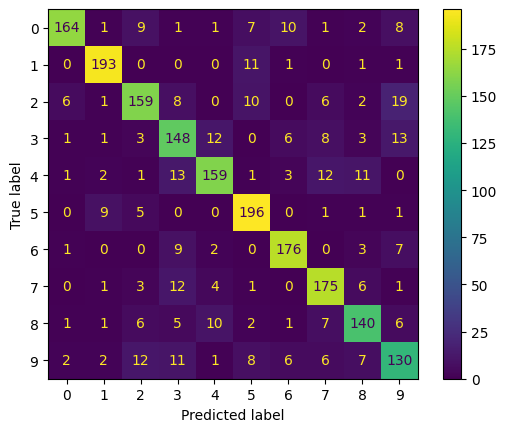

In [155]:
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline


predictions_y = np.argmax(model.predict(validation_x, batch_size=128), axis=1)
ConfusionMatrixDisplay.from_predictions(validation_y, predictions_y)

And now let's evaluate our model against the testing data.

In [156]:
model.evaluate(testing_x, testing_y, batch_size=128)

 1/16 [>.............................] - ETA: 0s - loss: 0.4916 - accuracy: 0.8438

16/16 [==============================] - 0s 911us/step - loss: 0.6027 - accuracy: 0.7983


[0.6026975512504578, 0.7982982993125916]

And now let's show a confusion matrix from our predictions with the testing dataset.

16/16 [==============================] - 0s 1ms/step


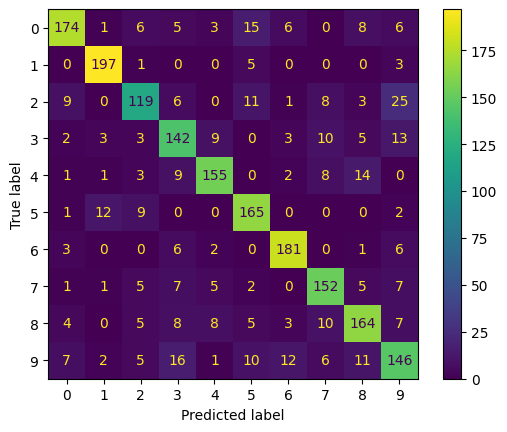

In [157]:
predictions_y = np.argmax(model.predict(testing_x, batch_size=128), axis=1)
ConfusionMatrixDisplay.from_predictions(testing_y, predictions_y)

Finally, let's see how our model predicts the genre of a random audio sample file from our dataset. For that, we will create a 'feature_extraction' function that will receive the path of a WAV file, extracts the same audio features included in the 'features_X_sec.csv' files using the 'librosa' library, and return them in a numpy array.

In [158]:
import librosa
import numpy as np
from numpy import mean, var, array


def feature_extraction(filename: str) -> array:
    all_features = []
    y, sr = librosa.load(filename)
    features = librosa.feature.chroma_stft(y=y, sr=sr)
    all_features.append(mean(features))
    all_features.append(var(features))
    features = librosa.feature.rms(y=y)
    all_features.append(mean(features))
    all_features.append(var(features))
    features = librosa.feature.spectral_centroid(y=y, sr=sr)
    all_features.append(mean(features))
    all_features.append(var(features))
    features = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    all_features.append(mean(features))
    all_features.append(var(features))
    features = librosa.feature.spectral_rolloff(y=y, sr=sr)
    all_features.append(mean(features))
    all_features.append(var(features))
    features = librosa.feature.zero_crossing_rate(y)
    all_features.append(mean(features))
    all_features.append(var(features))
    harmony, perceptr = librosa.effects.hpss(y=y)
    all_features.append(mean(harmony))
    all_features.append(var(harmony))
    all_features.append(mean(perceptr))
    all_features.append(var(perceptr))
    features, _ = librosa.beat.beat_track(y=y, sr=sr)
    all_features.append(features)
    # n_mfcc = number of MFCCs to return, using 20 to match the features_x_sec.csv files
    features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for x in range(20):
        all_features.append(features[x].mean())
        all_features.append(features[x].var())
    return np.array(all_features)

Now we will walk through the 'data/genres_original' folder and select a random audio sample file, then we will extract its audio features using our 'feature_extraction' function, and finally transform the features using the same standard_scaler transfomer we used for our training dataset, and predict its genre. 

We are not including the full contents of the 'genres_original' folder from the GTZAN dataset in our Github repo because it's very large, but you can download it from [here](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/data).

We've also incorporated an Audio control from the IPython.display library, allowing us to listen to the audio sample file for which we are predicting its genre.

In [167]:
import random
import os
from IPython.display import Audio


filepaths = []
for dirpath, dirnames, filenames in os.walk('data/genres_original'):
    for filename in filenames:
        if filename != '.DS_Store' and filename != 'desktop.ini':
            filepaths.append([os.path.join(dirpath, filename), filename[:filename.index('.')]])

test_index = random.randint(0, len(filepaths) - 1)
features = feature_extraction(filepaths[test_index][0]).reshape(1, -1)
scaled_features = standard_scaler.transform(features)
prediction = model.predict(scaled_features, batch_size=128)
print('File:', filepaths[test_index][0])
print('Song\'s genre:', filepaths[test_index][1])
print('Predicted genre:', labels[np.argmax(prediction)])
Audio(filepaths[test_index][0], autoplay=True)


1/1 [==============================] - 0s 15ms/step
File: data/genres_original/rock/rock.00065.wav
Song's genre: rock
Predicted genre: rock


Now let's save our model and its training history to use them on our streamlit app.

In [160]:
model.save('models/genre_prediction.h5')
np.save('models/training_history.npy', history)

/Users/echapa/music-ds/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

